In [27]:
from ephysvibe.structures.trials_data import TrialsData
import numpy as np
from ephysvibe.task import task_constants,def_task
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [18]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

In [88]:
data = TrialsData.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2022-12-16_10-30-59_Riesling_lip_e1_r1.h5")

In [89]:
t_before = 200
t_after = 900
in_out='in'
cgroup='good'
e_align="sample_on"
# select correct trials in block 1 (DMT)
trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
# check the in out correction
if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
# define task frame
task = def_task.create_task_frame(
    condition=data.condition[trials_b1],
    test_stimuli=data.test_stimuli[trials_b1],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
# select cluster group
if cgroup == 'all':
    neurons = np.where(data.clustersgroup != cgroup)[0]
else:
    neurons = np.where(data.clustersgroup == cgroup)[0]
# select trials with the condition in_out
task = task[np.logical_and(np.in1d(task['i_neuron'].values,neurons),task['in_out']==in_out)]
# split in two groups where the neurons in each have the same trials in in or out
task_1 = task[task['i_neuron']==neurons[0]].copy()
trials_neuron = task_1['trial_idx'].values
task_1['trial_idx'] = task_1['trial_idx'].replace(trials_neuron,np.arange(0,len(trials_neuron)))
t_neurons = task[np.in1d(task['trial_idx'].values,trials_neuron)]['i_neuron'].unique()
t_neurons_2=neurons[~np.in1d(neurons,t_neurons)]
task_all = [task_1]
if len(t_neurons_2) != 0:
    trials_neuron_2 = task[task['i_neuron']==t_neurons_2[0]]['trial_idx'].values
    trials_neuron = [trials_neuron,trials_neuron_2]
    t_neurons = [t_neurons,t_neurons_2]
    task_2 = task[task['i_neuron']==t_neurons_2[0]].copy()
    task_2['trial_idx'] = task_2['trial_idx'].replace(trials_neuron_2,np.arange(0,len(trials_neuron_2)))
    task_all = [task_1,task_2]
else:
    trials_neuron = [trials_neuron]
    t_neurons = [t_neurons]

sp_avg_all = []
for i_task, (trial_idx_n, neurons,task) in enumerate(zip(trials_neuron,t_neurons,task_all)):

    trials_s_on = data.code_samples[
        trials_b1[trial_idx_n],
        np.where(data.code_numbers[trials_b1[trial_idx_n]] == task_constants.EVENTS_B1[e_align])[
            1
        ],
    ]
    shifts = -(trials_s_on - t_before).astype(int)
    shifts = shifts[:,np.newaxis]
    shift_sp = TrialsData.indep_roll(data.sp_samples[trials_b1[trial_idx_n]][:,neurons], shifts, axis=2)[:,:, :t_before+t_after]
    #sp_avg = moving_average(shift_sp, win=win, step=step)
    #sp_avg = np.mean(shift_sp,axis=0)
    sp_avg_all.append(shift_sp)

In [90]:
sp_avg_all[0].shape

(308, 8, 1100)

In [91]:
sp_avg = []
for i_samp in ['o1_c1', 'o0_c0', 'o1_c5', 'o5_c1', 'o5_c5']:
    i_t=task_all[0][task_all[0]['sample']==i_samp]['trial_idx'].values
    sp_avg.append(np.mean(sp_avg_all[0][i_t],axis=0))
sp_avg=np.concatenate(sp_avg,axis=1)

In [68]:
task_all[0]['sample'].unique()

array(['o1_c1', 'o0_c0', 'o1_c5', 'o5_c1', 'o5_c5'], dtype=object)

In [92]:
#sp_avg = np.mean(sp_avg_all[0][i_t],axis=0)

In [93]:
sp_avg_z = z_score(sp_avg)
sp_avg_z.shape

(8, 5500)

In [95]:
model = PCA(n_components=8).fit(sp_avg_z.T)

In [96]:
W = model.components_
pc_s = W @ sp_avg

In [97]:
pc_s.shape

(8, 5500)

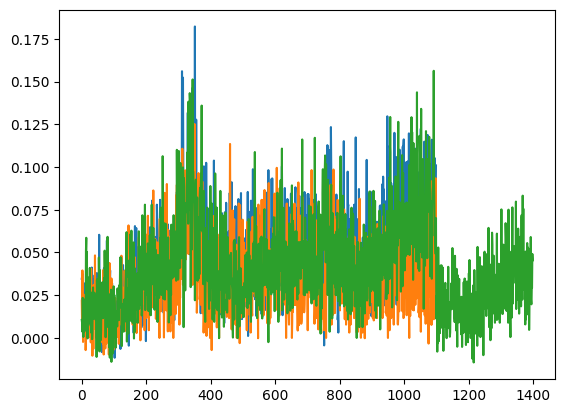

In [103]:

plt.plot(pc_s[0][:1100])
plt.plot(pc_s[0][1100:2200])
plt.plot(pc_s[0][2200:3600])

In [99]:
pc_s.shape

(8, 5500)

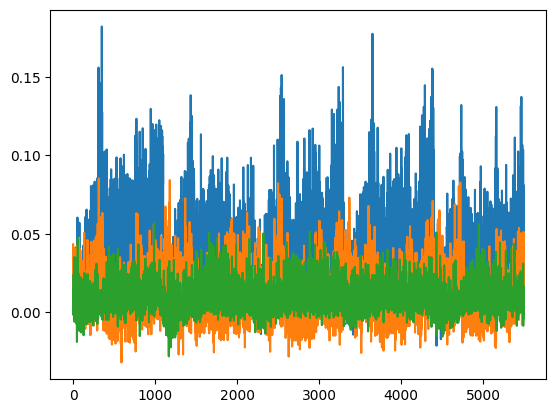

In [104]:
for pc in pc_s[:3]:
    plt.plot(pc)



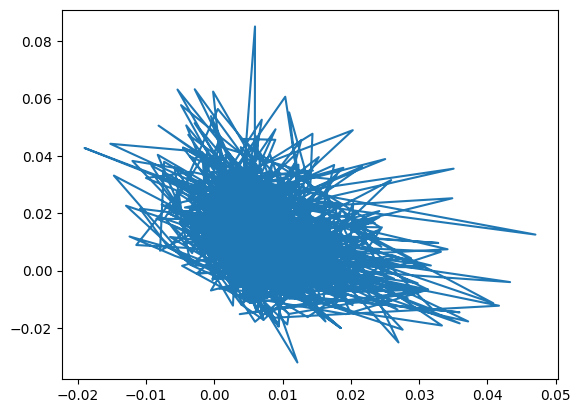

In [106]:
plt.plot(pc_s[2][:900],pc_s[1][:900])

In [ ]:

i_start = 0
i_end = 170
dat_right_left = np.reshape(dataset['spks'][:, :, i_start:i_end], (NN, -1)) # from 100 ms before stimulus to s after stimulus   
print(dat_right_left.shape)
dat_right_left_z = utils.z_score(dat_right_left)#dat_right_left - np.mean(dat_right_left, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(dat_right_left_z.T)
W = model.components_
pc_10ms = W @ np.reshape(dataset['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))
pc_10ms.shape